In [1]:
import sys
import pyspark.sql.functions as f
from pyspark.sql import SparkSession
import seaborn as sns
import pyspark
import matplotlib
import pandas as pd
import numpy as np

In [29]:
print (sys.version)
print (pyspark.__version__)
print(sns.__version__)
print(matplotlib.__version__)
print (pd.__version__)
print(np.__version__)

3.8.3 (default, Jul  2 2020, 17:30:36) [MSC v.1916 64 bit (AMD64)]
3.0.1
0.10.1
3.2.2
1.0.5
1.18.5


In [3]:

spark = SparkSession.builder.appName("task1").getOrCreate()

#Health Care Security - Insurance Enrollments 
df_medicaid = spark.read.format('csv').options(header='True', inferschema='false') \
    .load(r"Cleaned-Datasets\Health\Citywide_HRA-_Administered_Medicaid_Enrollees.csv").na.fill('')

renamed_df_medicaid = df_medicaid.select([f.col(col).alias(col.replace(' ', '_').replace('-','_')) for col in df_medicaid.columns])

renamed_df_medicaid.createOrReplaceTempView("MEDICAID_DATA")

df_CHIP = spark.read.format('csv').options(header='True', inferschema='false') \
    .load(r"Cleaned-Datasets\Health\Child_Health_Plus_Program_Enrollment__Beginning_2009_Date.csv").na.fill('')

renamed_df_CHIP = df_CHIP.select([f.col(col).alias(col.replace(' ', '_').replace('-','_')) for col in df_CHIP.columns])

renamed_df_CHIP.createOrReplaceTempView("CHIP_DATA")

# #Health Care Security - Infrastructure Availability
df_BED = spark.read.format('csv').options(header='True', inferschema='false') \
    .load(r"Cleaned-Datasets\Health\Nursing_Home_Weekly_Bed_Census__Beginning_2009.csv").na.fill('')

renamed_df_BED = df_BED.select([f.col(col).alias(col.replace(' ', '_').replace('-','_')) for col in df_BED.columns])

renamed_df_BED.createOrReplaceTempView("BED_AVAILABILITY_DATA")

# COVID-19 Cases-Hospotalization-Deaths Data
df_COVID = spark.read.format('csv').options(header='True', inferschema='false') \
    .load(r"Cleaned-Datasets\Covid-Cases-Data\COVID-19_Daily_Counts_of_Cases__Hospitalizations__and_Deaths.csv").na.fill('')

renamed_df_COVID = df_COVID.select([f.col(col).alias(col.replace(' ', '_').replace('-','_')) for col in df_COVID.columns])

renamed_df_COVID.createOrReplaceTempView("COVID_DATA")




Combining COVID and Health Insurance Enrollments.
Understanding the impact of COVID-Cases on Health Insurance Enrollments -Medicaid Enrolles,CHIP Enrolles

In [4]:

distribution = spark.sql("Select A.date_range,(C.p_score_medicaid_enrolles * 100) as p_score_medicaid_enrolles,B.cases,(A.p_score_CHIP_enrolles * 100) as p_score_CHIP_enrolles,A.CHIP_Enrolless,C.Total_Medicaid_Enrollees from (Select date_range,CHIP_Enrolless, (CHIP_Enrolless - avg(CHIP_Enrolless) OVER(ORDER BY date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ))/avg(CHIP_Enrolless) OVER(ORDER BY date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ) as p_score_CHIP_enrolles from (Select date_format (to_date(A.date,'yyyy/M/d'),'yyyy-MM-dd') as date_range,sum(cast(REPLACE(A.Number_of_Enrollees, ',','') as INT)) as CHIP_Enrolless from CHIP_DATA A where A.Economic_Region = 'New York City' group by date_format (to_date(A.date,'yyyy/M/d'),'yyyy-MM-dd'))) A left join (Select date_format(((to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy') - DAY(to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy'))) + 1),'yyyy-MM-dd') as date_range,sum(cast(REPLACE(b.case_count, ',','') as INT)) as cases from COVID_DATA B group by date_format(((to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy') - DAY(to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy'))) + 1),'yyyy-MM-dd')) B on A.date_range = B.date_range left join (Select date_range,Total_Medicaid_Enrollees, (Total_Medicaid_Enrollees - avg(Total_Medicaid_Enrollees) OVER(ORDER BY date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ))/avg(Total_Medicaid_Enrollees) OVER(ORDER BY date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ) as p_score_medicaid_enrolles from (Select date_format(((to_date(A.month,'MM/dd/yyyy') - DAY(to_date(A.month,'MM/dd/yyyy'))) + 1),'yyyy-MM-dd') as date_range,A.month,sum(cast(REPLACE(A.Total_HRA_Enrolled_Medical_Assistance_Individuals, ',','') as INT)) as Total_Medicaid_Enrollees from MEDICAID_DATA A  group by date_format(((to_date(A.month,'MM/dd/yyyy') - DAY(to_date(A.month,'MM/dd/yyyy'))) + 1),'yyyy-MM-dd'),A.month order by 1))  C on A.date_range = C.date_range where to_date(A.date_range,'yyyy-M-dd') between '2019-09-01' and '2020-10-01' ")
distribution.show(5)

+----------+-------------------------+-----+---------------------+--------------+------------------------+
|date_range|p_score_medicaid_enrolles|cases|p_score_CHIP_enrolles|CHIP_Enrolless|Total_Medicaid_Enrollees|
+----------+-------------------------+-----+---------------------+--------------+------------------------+
|2019-09-01|      -16.568141538053478| null|   23.662579737599078|        162774|                 1556600|
|2019-10-01|       -16.56451883598631| null|   23.886046515915083|        164577|                 1543973|
|2019-11-01|      -16.144210312659744| null|   23.882303699983247|        166111|                 1539231|
|2019-12-01|      -16.725170353585895| null|    23.57380961571401|        167257|                 1516282|
|2020-01-01|       -16.49776699934404| null|   23.182440348992486|        168346|                 1508507|
+----------+-------------------------+-----+---------------------+--------------+------------------------+
only showing top 5 rows



Printing the Dataset Charecteristics

In [5]:

print((renamed_df_medicaid.count(), len(renamed_df_medicaid.columns)))
print((renamed_df_CHIP.count(), len(renamed_df_CHIP.columns)))
print((renamed_df_BED.count(), len(renamed_df_BED.columns)))
print((renamed_df_COVID.count(), len(renamed_df_COVID.columns)))

(164, 6)
(229386, 9)
(283851, 35)
(269, 39)


plotting the time-series for Understanding the impact of COVID-Cases on Health Insurance Enrollments-
Medicaid Enrolles,CHIP Enrolles


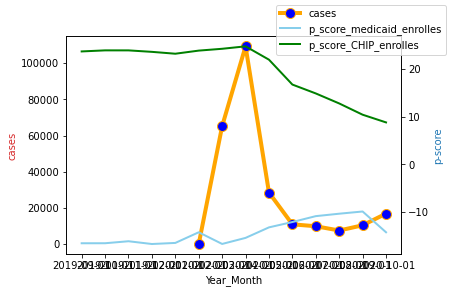

In [6]:
import matplotlib.pyplot as plt

pdf_df = (
    distribution.select(
        "date_range",
        "p_score_medicaid_enrolles",
        "p_score_CHIP_enrolles",
        "cases"
    )
    .orderBy("date_range")
    .toPandas()
)

#Missing Value Imputation with mean scores
pdf_df["p_score_medicaid_enrolles"].fillna(pdf_df["p_score_medicaid_enrolles"].mean(), inplace=True)
pdf_df["p_score_CHIP_enrolles"].fillna(pdf_df["p_score_CHIP_enrolles"].mean(), inplace=True)

# Timeseries Plots

# multiple line plot
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year_Month')
ax1.set_ylabel('cases', color=color)
ax1.plot("date_range", "cases",data=pdf_df, marker='o', markerfacecolor='blue', markersize=10, color='orange', linewidth=4)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('p-score', color=color)  # we already handled the x-label with ax1
ax2.plot("date_range", "p_score_medicaid_enrolles",data=pdf_df, marker='', color='skyblue', linewidth=2)
ax2.plot("date_range", "p_score_CHIP_enrolles",data=pdf_df,  marker='', color='green', linewidth=2)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.rcParams["figure.figsize"] = (20,10)
fig.legend()
plt.show()


In [7]:
distribution = spark.sql("Select A.*,B.cases from (Select a.date_range ,((((a.nursing_home_beds_available_prop) - avg(a.nursing_home_beds_available_prop) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ))/avg(a.nursing_home_beds_available_prop) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW )) *100) as p_score_nursing_home_beds_available,((((a.Pediatric_Beds_available_prop/NVL(b.cases,1)) - avg(a.Pediatric_Beds_available_prop/NVL(b.cases,1)) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ))/avg(a.Pediatric_Beds_available_prop/NVL(b.cases,1)) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW )) * 100) as p_score_Pediatric_Beds_available,((((a.Traumatic_Brain_Injury_Beds_Available_prop/NVL(b.cases,1)) - avg(a.Traumatic_Brain_Injury_Beds_Available_prop/NVL(b.cases,1)) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ))/avg(a.Traumatic_Brain_Injury_Beds_Available_prop/NVL(b.cases,1)) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW )) *100) as p_score_Traumatic_Brain_Injury_Beds_Available,((((a.Adult_Day_Health_Care_Slots_Available_prop) - avg(a.Adult_Day_Health_Care_Slots_Available_prop) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ))/avg(a.Adult_Day_Health_Care_Slots_Available_prop) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW )) * 100) as p_score_Adult_Day_Health_Care_Slots_Available,((((a.Ventilator_Beds_Available_prop/NVL(b.cases,1)) - avg(a.Ventilator_Beds_Available_prop/NVL(b.cases,1)) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ))/avg(a.Ventilator_Beds_Available_prop/NVL(b.cases,1)) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW )) * 100) as p_score_Ventilator_Beds_Available,((((a.nursing_home_beds_available_prop/NVL(b.cases,1)) - avg(a.nursing_home_beds_available_prop/NVL(b.cases,1)) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ))/avg(a.nursing_home_beds_available_prop/NVL(b.cases,1)) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW )) * 100) as p_score_nursing_home_beds_pandemic_avail,((((a.Adult_Day_Health_Care_Slots_Available_prop/NVL(b.cases,1)) - avg(a.Adult_Day_Health_Care_Slots_Available_prop/NVL(b.cases,1)) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ))/avg(a.Adult_Day_Health_Care_Slots_Available_prop/NVL(b.cases,1)) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW )) * 100) as p_score_Adult_Day_Health_Care_Slots_pandemic_Avail, (a.Pediatric_Beds_available_prop/NVL(b.cases,1)) as Pediatric_Beds_available_prop,( a.Traumatic_Brain_Injury_Beds_Available_prop/NVL(b.cases,1)) as Traumatic_Brain_Injury_Beds_Available_prop,(a.nursing_home_beds_available_prop/NVL(b.cases,1))  as nursing_home_beds_available_prop_pandemic from  (Select date_format(((to_date(A.CENSUS_DATE,'MM/dd/yyyy') - DAY(to_date(A.CENSUS_DATE,'MM/dd/yyyy'))) + 1),'yyyy-MM-dd') as date_range, (avg(cast(REPLACE(A.Nursing_Home_Beds_Available, ',','') as INT))) as NURSING_HOME_BEDS_AVAILABLE_PROP, (avg(cast(REPLACE(A.Pediatric_Beds_Available, ',','') as INT))) as Pediatric_Beds_available_PROP, (avg(cast(REPLACE(A.Ventilator_Beds_Available, ',','') as INT))) as Ventilator_Beds_Available_prop, (avg(cast(REPLACE(A.Traumatic_Brain_Injury_Beds_Available, ',','') as INT))) as Traumatic_Brain_Injury_Beds_Available_Prop,(avg(cast(REPLACE(A.Adult_Day_Health_Care_Slots_Available, ',','') as INT))) as Adult_Day_Health_Care_Slots_Available_Prop from BED_AVAILABILITY_DATA A group by date_format(((to_date(A.CENSUS_DATE,'MM/dd/yyyy') - DAY(to_date(A.CENSUS_DATE,'MM/dd/yyyy'))) + 1),'yyyy-MM-dd')) A left join (Select date_format(((to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy') - DAY(to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy'))) + 1),'yyyy-MM-dd') as date_range,sum(cast(REPLACE(b.HOSPITALIZED_COUNT, ',','') as INT)) as cases from COVID_DATA B group by date_format(((to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy') - DAY(to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy'))) + 1),'yyyy-MM-dd')) B on A.date_range = B.date_range ) A left join (Select date_format(((to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy') - DAY(to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy'))) + 1),'yyyy-MM-dd') as date_range,sum(cast(REPLACE(b.case_count, ',','') as INT)) as cases from COVID_DATA B group by date_format(((to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy') - DAY(to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy'))) + 1),'yyyy-MM-dd')) B on A.date_range = B.date_range where to_date(A.date_range,'yyyy-M-dd') between '2019-09-01' and '2020-11-01'")
distribution.show(5)                         

+----------+-----------------------------------+--------------------------------+---------------------------------------------+---------------------------------------------+---------------------------------+----------------------------------------+--------------------------------------------------+-----------------------------+------------------------------------------+-----------------------------------------+-----+
|date_range|p_score_nursing_home_beds_available|p_score_Pediatric_Beds_available|p_score_Traumatic_Brain_Injury_Beds_Available|p_score_Adult_Day_Health_Care_Slots_Available|p_score_Ventilator_Beds_Available|p_score_nursing_home_beds_pandemic_avail|p_score_Adult_Day_Health_Care_Slots_pandemic_Avail|Pediatric_Beds_available_prop|Traumatic_Brain_Injury_Beds_Available_prop|nursing_home_beds_available_prop_pandemic|cases|
+----------+-----------------------------------+--------------------------------+---------------------------------------------+-------------------------------

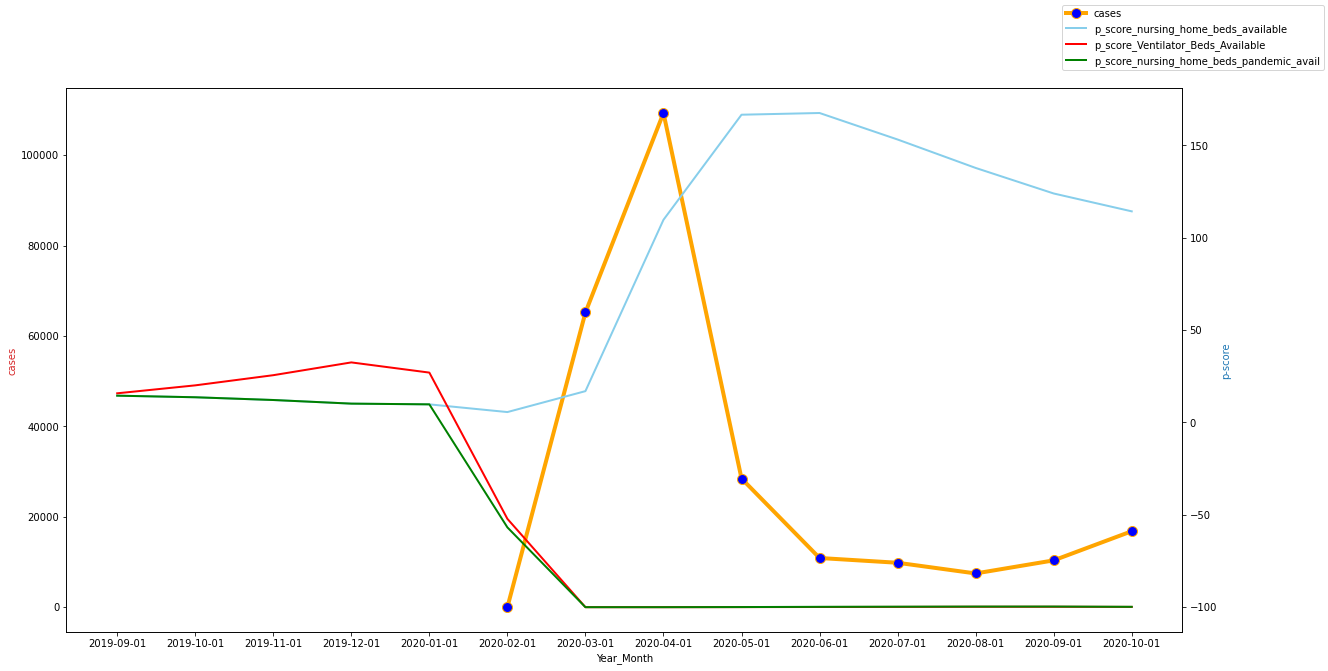

In [8]:


import matplotlib.pyplot as plt

pdf_df = (
    distribution.select(
        "date_range",
        "p_score_nursing_home_beds_available",
        #"p_score_Pediatric_Beds_available",
        "p_score_Ventilator_Beds_Available",
        #"p_score_Traumatic_Brain_Injury_Beds_Available",
        #"p_score_Adult_Day_Health_Care_Slots_Available",
        #"p_score_Adult_Day_Health_Care_Slots_pandemic_Avail",
        "p_score_nursing_home_beds_pandemic_avail",
        "cases"
    )
    .orderBy("date_range")
    .toPandas()
)

#missing value imputation with mean values
pdf_df["p_score_nursing_home_beds_available"].fillna(pdf_df["p_score_nursing_home_beds_available"].mean(), inplace=True)
#pdf_df["p_score_Pediatric_Beds_available"].fillna(pdf_df["p_score_Pediatric_Beds_available"].mean(), inplace=True)
pdf_df["p_score_Ventilator_Beds_Available"].fillna(pdf_df["p_score_Ventilator_Beds_Available"].mean(), inplace=True)
#pdf_df["p_score_Traumatic_Brain_Injury_Beds_Available"].fillna(pdf_df["p_score_Traumatic_Brain_Injury_Beds_Available"].mean(), inplace=True)
pdf_df["p_score_nursing_home_beds_pandemic_avail"].fillna(pdf_df["p_score_nursing_home_beds_pandemic_avail"].mean(), inplace=True)

# Time-Series Plot
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year_Month')
ax1.set_ylabel('cases', color=color)
ax1.plot("date_range", "cases",data=pdf_df, marker='o', markerfacecolor='blue', markersize=10, color='orange', linewidth=4)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('p-score', color=color)  # we already handled the x-label with ax1
ax2.plot("date_range", "p_score_nursing_home_beds_available",data=pdf_df, marker='', color='skyblue', linewidth=2)
#ax2.plot("date_range", "p_score_Pediatric_Beds_available",data=pdf_df,  marker='', color='olive', linewidth=2)
ax2.plot("date_range", "p_score_Ventilator_Beds_Available",data=pdf_df,  marker='', color='red', linewidth=2)
#ax2.plot("date_range", "p_score_Traumatic_Brain_Injury_Beds_Available",data=pdf_df,  marker='', color='purple', linewidth=2)
ax2.plot("date_range", "p_score_nursing_home_beds_pandemic_avail",data=pdf_df,  marker='', color='green', linewidth=2)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.rcParams["figure.figsize"] = (20,10)
fig.legend()
plt.show()



In [9]:


spark = SparkSession.builder.appName("task2").getOrCreate()

# Covid's Impact on Public Saftey - Aggregating shooting data
df = spark.read.format('csv').options(header='True', inferschema='false') \
    .load(r"Cleaned-Datasets\Crime\NYPD_Shooting_Incident_Data__Year_To_Date_.csv").na.fill('')

shooting_data_df = df.select([f.col(col).alias(col.replace(' ', '_').replace('-','_')) for col in df.columns])

shooting_data_df.createOrReplaceTempView("SHOOTING_DATA_2020")

df = spark.read.format('csv').options(header='True', inferschema='false') \
    .load(r"Cleaned-Datasets\Crime\NYPD_Shooting_Incident_Data__Historic_.csv").na.fill('')

shooting_data_df_1 = df.select([f.col(col).alias(col.replace(' ', '_').replace('-','_')) for col in df.columns])

shooting_data_df_1.createOrReplaceTempView("SHOOTING_DATA_HISTORIC")

shooting_data_df_1.show(5)




+------------+----------+----------+--------+--------+-----------------+-------------+-----------------------+--------------+--------+---------+-------------+-------+--------+----------+----------+-----------------+------------------+--------------------+
|INCIDENT_KEY|OCCUR_DATE|OCCUR_TIME|    BORO|PRECINCT|JURISDICTION_CODE|LOCATION_DESC|STATISTICAL_MURDER_FLAG|PERP_AGE_GROUP|PERP_SEX|PERP_RACE|VIC_AGE_GROUP|VIC_SEX|VIC_RACE|X_COORD_CD|Y_COORD_CD|         Latitude|         Longitude|             Lon_Lat|
+------------+----------+----------+--------+--------+-----------------+-------------+-----------------------+--------------+--------+---------+-------------+-------+--------+----------+----------+-----------------+------------------+--------------------+
|    74146165|08/14/2010|   3:11:00|  QUEENS|     113|                0|             |                  false|              |        |         |        25-44|      M|   BLACK|   1046573|    183057|40.66891477200004|-73.7753409969999

In [10]:


spark = SparkSession.builder.appName("task3").getOrCreate()

# Covid's Impact on Public Saftey - Aggregating arrest data
df_arrest = spark.read.format('csv').options(header='True', inferschema='false') \
    .load(r"Cleaned-Datasets\Crime\NYPD_Arrest_Data__Year_to_Date_.csv").na.fill('')

renamed_df = df_arrest.select([f.col(col).alias(col.replace(' ', '_').replace('-','_')) for col in df_arrest.columns])

renamed_df.createOrReplaceTempView("ARREST_DATA_2020")

df_arrest_1 = spark.read.format('csv').options(header='True', inferschema='false') \
    .load(r"Cleaned-Datasets\Crime\NYPD_Arrests_Data__Historic_.csv").na.fill('')

renamed_df_1 = df_arrest_1.select([f.col(col).alias(col.replace(' ', '_').replace('-','_')) for col in df_arrest_1.columns])

renamed_df_1.createOrReplaceTempView("ARREST_DATA_HISTORIC")

renamed_df_1.show(5)

+----------+-----------+-----+--------------------+-----+--------------------+----------+----------+-----------+---------------+-----------------+---------+--------+--------------+----------+----------+------------------+------------------+--------------------+
|ARREST_KEY|ARREST_DATE|PD_CD|             PD_DESC|KY_CD|           OFNS_DESC|  LAW_CODE|LAW_CAT_CD|ARREST_BORO|ARREST_PRECINCT|JURISDICTION_CODE|AGE_GROUP|PERP_SEX|     PERP_RACE|X_COORD_CD|Y_COORD_CD|          Latitude|         Longitude|             Lon_Lat|
+----------+-----------+-----+--------------------+-----+--------------------+----------+----------+-----------+---------------+-----------------+---------+--------+--------------+----------+----------+------------------+------------------+--------------------+
|  10837169| 04/02/2006|     |                    |     |                    |          |          |          Q|            101|                0|         |       M|         BLACK| 1051775.0|  159727.0|40.604840985

In [11]:
# Dataset Charecteristics
print((shooting_data_df_1.count(), len(shooting_data_df_1.columns)))
print((renamed_df_1.count(), len(renamed_df_1.columns)))

(21626, 19)
(5012956, 19)


In [12]:
distribution = spark.sql("Select A.date_range, ((A.shooting_count - avg(A.shooting_count) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ))/avg(A.shooting_count) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ) * 100) as p_score_shooting_incidents,((C.arrest_count - avg(C.arrest_count) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ))/avg(C.arrest_count) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ) * 100) as p_score_arrests,B.cases,A.shooting_count,C.arrest_count from (Select date_format(((to_date(A.OCCUR_DATE,'MM/dd/yyyy') - DAY(to_date(A.OCCUR_DATE,'MM/dd/yyyy'))) + 1),'yyyy-MM-dd') as date_range, count(distinct (A.INCIDENT_KEY)) as shooting_count from (Select * from SHOOTING_DATA_2020 UNION Select * from SHOOTING_DATA_HISTORIC) A group by date_format(((to_date(A.OCCUR_DATE,'MM/dd/yyyy') - DAY(to_date(A.OCCUR_DATE,'MM/dd/yyyy'))) + 1),'yyyy-MM-dd') order by 1) A left join (Select date_format(((to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy') - DAY(to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy'))) + 1),'yyyy-MM-dd') as date_range,sum(cast(REPLACE(b.case_count, ',','') as INT)) as cases from COVID_DATA B group by date_format(((to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy') - DAY(to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy'))) + 1),'yyyy-MM-dd')) b on A.date_range = b.date_range left join (Select ((to_date(A.ARREST_DATE,'MM/dd/yyyy') - DAY(to_date(A.ARREST_DATE,'MM/dd/yyyy'))) + 1) as date_range, count(distinct (A.ARREST_KEY)) as arrest_count from (Select * from ARREST_DATA_2020 UNION Select * from ARREST_DATA_HISTORIC) A where to_date(A.ARREST_DATE,'MM/dd/yyyy') > '2019-06-01' group by ((to_date(A.ARREST_DATE,'MM/dd/yyyy') - DAY(to_date(A.ARREST_DATE,'MM/dd/yyyy'))) + 1) order by 1 ) c on A.date_range = c.date_range where to_date(A.date_range,'yyyy-M-dd') between '2019-09-01' and '2020-11-01'")
distribution.show(10)

+----------+--------------------------+-------------------+------+--------------+------------+
|date_range|p_score_shooting_incidents|    p_score_arrests| cases|shooting_count|arrest_count|
+----------+--------------------------+-------------------+------+--------------+------------+
|2019-09-01|                       0.0|                0.0|  null|            67|       16656|
|2019-10-01|        -3.875968992248062| 2.3824175824175824|  null|            62|       17469|
|2019-11-01|       -16.201117318435752| -6.106178655553542|  null|            50|       15546|
|2019-12-01|        -4.680851063829787|-13.837113792885575|  null|            56|       13637|
|2020-01-01|         9.634551495016606| 1.7312749279683985|  null|            66|       16171|
|2020-02-01|        -21.96531791907514| -2.231677391496663|     1|            45|       15472|
|2020-03-01|         -2.48756218905473| -14.67188251396441| 65190|            56|       13181|
|2020-04-01|       -2.1834061135371177| -43.002911

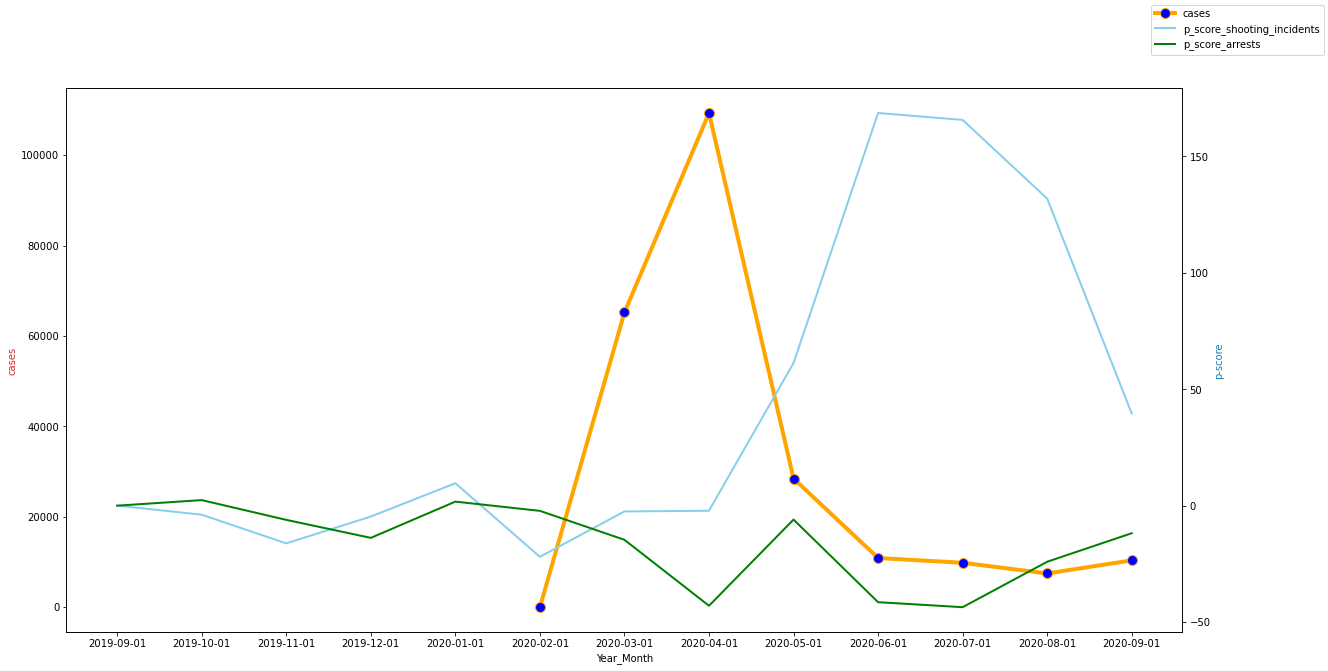

In [13]:
import matplotlib.pyplot as plt

pdf_df = (
    distribution.select(
        "date_range",
        "p_score_shooting_incidents",
        "p_score_arrests",
        "cases"
    )
    .orderBy("date_range")
    .toPandas()
)


# multiple line plot
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Year_Month')
ax1.set_ylabel('cases', color=color)
ax1.plot("date_range", "cases",data=pdf_df, marker='o', markerfacecolor='blue', markersize=10, color='orange', linewidth=4)


ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('p-score', color=color)  # we already handled the x-label with ax1
ax2.plot("date_range", "p_score_shooting_incidents",data=pdf_df, marker='', color='skyblue', linewidth=2)
ax2.plot("date_range", "p_score_arrests",data=pdf_df,  marker='', color='green', linewidth=2)

#ax2.tick_params(axis='y', labelcolor=color)

#fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.rcParams["figure.figsize"] = (20,10)
fig.legend()
plt.show()



In [14]:

spark = SparkSession.builder.appName("task6").getOrCreate()

df_unemployment = spark.read.format('csv').options(header='True', inferschema='false') \
    .load(r"Cleaned-Datasets\Linear_Regression\dhs_employment_data.csv").na.fill('')

renamed_df_unemployment = df_unemployment.select([f.col(col).alias(col.replace(' ', '_').replace('-','_')) for col in df_unemployment.columns])

renamed_df_unemployment.createOrReplaceTempView("UNEMPLOYMENT_DATA")

df_mental_health = spark.read.format('csv').options(header='True', inferschema='false') \
    .load(r"Cleaned-Datasets\Health\Mental-Health-Data.csv").na.fill('')

renamed_df_mental_health = df_mental_health.select([f.col(col).alias(col.replace(' ', '_').replace('-','_')) for col in df_mental_health.columns])

renamed_df_mental_health.createOrReplaceTempView("Mental_Health_DATA")


distribution_health_insu = spark.sql("Select A.date_range as date_3,A.CHIP_Enrolless,C.Total_Medicaid_Enrollees from (Select date_range,CHIP_Enrolless, (CHIP_Enrolless - avg(CHIP_Enrolless) OVER(ORDER BY date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ))/avg(CHIP_Enrolless) OVER(ORDER BY date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ) as p_score_CHIP_enrolles from (Select date_format (to_date(A.date,'yyyy/M/d'),'yyyy-MM-dd') as date_range,sum(cast(REPLACE(A.Number_of_Enrollees, ',','') as INT)) as CHIP_Enrolless from CHIP_DATA A where A.Economic_Region = 'New York City' group by date_format (to_date(A.date,'yyyy/M/d'),'yyyy-MM-dd'))) A left join (Select date_format(((to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy') - DAY(to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy'))) + 1),'yyyy-MM-dd') as date_range,sum(cast(REPLACE(b.case_count, ',','') as INT)) as cases from COVID_DATA B group by date_format(((to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy') - DAY(to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy'))) + 1),'yyyy-MM-dd')) B on A.date_range = B.date_range left join (Select date_range,Total_Medicaid_Enrollees, (Total_Medicaid_Enrollees - avg(Total_Medicaid_Enrollees) OVER(ORDER BY date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ))/avg(Total_Medicaid_Enrollees) OVER(ORDER BY date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ) as p_score_medicaid_enrolles from (Select date_format(((to_date(A.month,'MM/dd/yyyy') - DAY(to_date(A.month,'MM/dd/yyyy'))) + 1),'yyyy-MM-dd') as date_range,A.month,sum(cast(REPLACE(A.Total_HRA_Enrolled_Medical_Assistance_Individuals, ',','') as INT)) as Total_Medicaid_Enrollees from MEDICAID_DATA A  group by date_format(((to_date(A.month,'MM/dd/yyyy') - DAY(to_date(A.month,'MM/dd/yyyy'))) + 1),'yyyy-MM-dd'),A.month order by 1))  C on A.date_range = C.date_range where to_date(A.date_range,'yyyy-M-dd') between '2019-01-01' and '2020-11-01'")
distribution_unemployment = spark.sql(" Select date_format(to_date(DATE,'M/d/yy'),'yyyy-MM-dd') as date_4, sum(avg_Adults_in_Shelter + avg_Children_in_Shelter) as Homeless_Numbers,sum(total_nonfarm) as Employed from UNEMPLOYMENT_DATA group by date_format(to_date(DATE,'M/d/yy'),'yyyy-MM-dd')")
distribution_mental_health = spark.sql(" Select date_format(to_date(DATE,'M/d/yyyy'),'yyyy-MM-dd') as date_5,avg(value) as Mental_Anxiety_Score from Mental_Health_DATA A  group by date_format(to_date(DATE,'M/d/yyyy'),'yyyy-MM-dd') order by 1")
distribution_crime = spark.sql("Select A.date_range as date_1, (A.shooting_count - avg(A.shooting_count) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ))/avg(A.shooting_count) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ) as p_score_shooting_incidents,(C.arrest_count - avg(C.arrest_count) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ))/avg(C.arrest_count) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ) as p_score_arrests,B.cases,A.shooting_count,C.arrest_count from (Select date_format(((to_date(A.OCCUR_DATE,'MM/dd/yyyy') - DAY(to_date(A.OCCUR_DATE,'MM/dd/yyyy'))) + 1),'yyyy-MM-dd') as date_range, count(distinct (A.INCIDENT_KEY)) as shooting_count from (Select * from SHOOTING_DATA_2020 UNION Select * from SHOOTING_DATA_HISTORIC) A group by date_format(((to_date(A.OCCUR_DATE,'MM/dd/yyyy') - DAY(to_date(A.OCCUR_DATE,'MM/dd/yyyy'))) + 1),'yyyy-MM-dd') order by 1) A left join (Select date_format(((to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy') - DAY(to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy'))) + 1),'yyyy-MM-dd') as date_range,sum(cast(REPLACE(b.case_count, ',','') as INT)) as cases from COVID_DATA B group by date_format(((to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy') - DAY(to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy'))) + 1),'yyyy-MM-dd')) b on A.date_range = b.date_range left join (Select ((to_date(A.ARREST_DATE,'MM/dd/yyyy') - DAY(to_date(A.ARREST_DATE,'MM/dd/yyyy'))) + 1) as date_range, count(distinct (A.ARREST_KEY)) as arrest_count from (Select * from ARREST_DATA_2020 UNION Select * from ARREST_DATA_HISTORIC) A where to_date(A.ARREST_DATE,'MM/dd/yyyy') > '2019-06-01' group by ((to_date(A.ARREST_DATE,'MM/dd/yyyy') - DAY(to_date(A.ARREST_DATE,'MM/dd/yyyy'))) + 1) order by 1 ) c on A.date_range = c.date_range where to_date(A.date_range,'yyyy-M-dd') between '2019-01-01' and '2020-11-01'")
distribution_health_infra = spark.sql("Select A.*,B.cases as Case_count from (Select a.date_range,(((a.nursing_home_beds_available_prop) - avg(a.nursing_home_beds_available_prop) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ))/avg(a.nursing_home_beds_available_prop) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW )) as p_score_nursing_home_beds_available,(((a.Pediatric_Beds_available_prop/NVL(b.cases,1)) - avg(a.Pediatric_Beds_available_prop/NVL(b.cases,1)) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ))/avg(a.Pediatric_Beds_available_prop/NVL(b.cases,1)) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW )) as p_score_Pediatric_Beds_available,(((a.Traumatic_Brain_Injury_Beds_Available_prop/NVL(b.cases,1)) - avg(a.Traumatic_Brain_Injury_Beds_Available_prop/NVL(b.cases,1)) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ))/avg(a.Traumatic_Brain_Injury_Beds_Available_prop/NVL(b.cases,1)) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW )) as p_score_Traumatic_Brain_Injury_Beds_Available,(((a.Adult_Day_Health_Care_Slots_Available_prop) - avg(a.Adult_Day_Health_Care_Slots_Available_prop) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ))/avg(a.Adult_Day_Health_Care_Slots_Available_prop) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW )) as p_score_Adult_Day_Health_Care_Slots_Available,(((a.Ventilator_Beds_Available_prop/NVL(b.cases,1)) - avg(a.Ventilator_Beds_Available_prop/NVL(b.cases,1)) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ))/avg(a.Ventilator_Beds_Available_prop/NVL(b.cases,1)) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW )) as p_score_Ventilator_Beds_Available,(((a.nursing_home_beds_available_prop/NVL(b.cases,1)) - avg(a.nursing_home_beds_available_prop/NVL(b.cases,1)) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ))/avg(a.nursing_home_beds_available_prop/NVL(b.cases,1)) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW )) as p_score_nursing_home_beds_pandemic_avail,(((a.Adult_Day_Health_Care_Slots_Available_prop/NVL(b.cases,1)) - avg(a.Adult_Day_Health_Care_Slots_Available_prop/NVL(b.cases,1)) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW ))/avg(a.Adult_Day_Health_Care_Slots_Available_prop/NVL(b.cases,1)) OVER(ORDER BY a.date_range ROWS BETWEEN 48 PRECEDING AND CURRENT ROW )) as p_score_Adult_Day_Health_Care_Slots_pandemic_Avail, (a.Pediatric_Beds_available_prop/NVL(b.cases,1)) as Pediatric_Beds_available_prop,( a.Traumatic_Brain_Injury_Beds_Available_prop/NVL(b.cases,1)) as Traumatic_Brain_Injury_Beds_Available_prop,(a.nursing_home_beds_available_prop/NVL(b.cases,1))  as nursing_home_beds_available_prop_pandemic,(a.Ventilator_Beds_Available_prop/NVL(b.cases,1))  as Ventilator_Beds_Available_prop_pandemic from  (Select date_format(((to_date(A.CENSUS_DATE,'MM/dd/yyyy') - DAY(to_date(A.CENSUS_DATE,'MM/dd/yyyy'))) + 1),'yyyy-MM-dd') as date_range, (avg(cast(REPLACE(A.Nursing_Home_Beds_Available, ',','') as INT))) as NURSING_HOME_BEDS_AVAILABLE_PROP, (avg(cast(REPLACE(A.Pediatric_Beds_Available, ',','') as INT))) as Pediatric_Beds_available_PROP, (avg(cast(REPLACE(A.Ventilator_Beds_Available, ',','') as INT))) as Ventilator_Beds_Available_prop, (avg(cast(REPLACE(A.Traumatic_Brain_Injury_Beds_Available, ',','') as INT))) as Traumatic_Brain_Injury_Beds_Available_Prop,(avg(cast(REPLACE(A.Adult_Day_Health_Care_Slots_Available, ',','') as INT))) as Adult_Day_Health_Care_Slots_Available_Prop from BED_AVAILABILITY_DATA A group by date_format(((to_date(A.CENSUS_DATE,'MM/dd/yyyy') - DAY(to_date(A.CENSUS_DATE,'MM/dd/yyyy'))) + 1),'yyyy-MM-dd')) A left join (Select date_format(((to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy') - DAY(to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy'))) + 1),'yyyy-MM-dd') as date_range,sum(cast(REPLACE(b.HOSPITALIZED_COUNT, ',','') as INT)) as cases from COVID_DATA B group by date_format(((to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy') - DAY(to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy'))) + 1),'yyyy-MM-dd')) B on A.date_range = B.date_range ) A left join (Select date_format(((to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy') - DAY(to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy'))) + 1),'yyyy-MM-dd') as date_range,sum(cast(REPLACE(b.case_count, ',','') as INT)) as cases from COVID_DATA B group by date_format(((to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy') - DAY(to_date(B.DATE_OF_INTEREST,'MM/dd/yyyy'))) + 1),'yyyy-MM-dd')) B on A.date_range = B.date_range where to_date(A.date_range,'yyyy-M-dd') between '2019-01-01' and '2020-11-01'")

In [15]:
# Dataset Charecteristics
print((renamed_df_mental_health.count(), len(renamed_df_mental_health.columns)))

(44, 12)


In [16]:

left_join_1 = distribution_health_insu.join(distribution_unemployment, distribution_health_insu.date_3 == distribution_unemployment.date_4,how='left')
left_join_2 = left_join_1.join(distribution_mental_health,left_join_1.date_3 == distribution_mental_health.date_5,how='left')
left_join_3 = left_join_2.join(distribution_crime,left_join_2.date_3 ==distribution_crime.date_1,how='left')
left_join_4 = left_join_3.join(distribution_health_infra, left_join_3.date_3 == distribution_health_infra.date_range, how='left')
left_join_4.show(5)

+----------+--------------+------------------------+----------+----------------+-----------+----------+--------------------+----------+--------------------------+--------------------+-----+--------------+------------+----------+-----------------------------------+--------------------------------+---------------------------------------------+---------------------------------------------+---------------------------------+----------------------------------------+--------------------------------------------------+-----------------------------+------------------------------------------+-----------------------------------------+---------------------------------------+----------+
|    date_3|CHIP_Enrolless|Total_Medicaid_Enrollees|    date_4|Homeless_Numbers|   Employed|    date_5|Mental_Anxiety_Score|    date_1|p_score_shooting_incidents|     p_score_arrests|cases|shooting_count|arrest_count|date_range|p_score_nursing_home_beds_available|p_score_Pediatric_Beds_available|p_score_Traumatic_Bra

In [17]:
#defining functions for plotting correlation matric and regression graphs
def cor_matrix(x):
    correlation_matrix = x.corr().round(2)
    sns.heatmap(correlation_matrix, cmap='YlGnBu')
    plt.tight_layout()
    plt.plot()
    #plt.legend()
    plt.show()


def reg(data, x, y):
    sns.regplot(data=data, x=x, y=y)
    plt.plot()
    #plt.legend()
    plt.show()



                             cases  CHIP_Enrolless  Total_Medicaid_Enrollees
cases                     1.000000        0.622225                 -0.521682
CHIP_Enrolless            0.622225        1.000000                 -0.906308
Total_Medicaid_Enrollees -0.521682       -0.906308                  1.000000


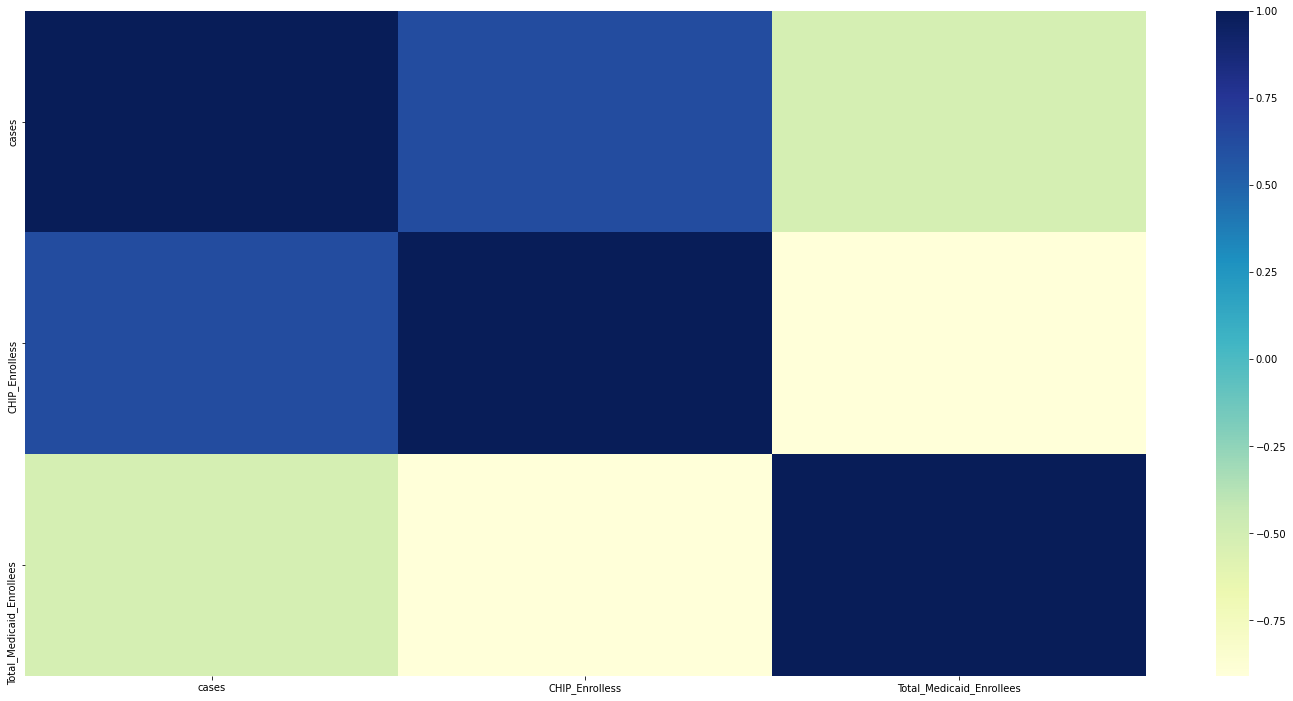

In [18]:

regression_df = (
    left_join_4.select(
        "cases",
        "CHIP_Enrolless",
        "Total_Medicaid_Enrollees",
    )
    .orderBy("date_3")
    .toPandas()
)
regression_df["cases"].fillna(0, inplace=True)
regression_df["CHIP_Enrolless"].fillna(regression_df["CHIP_Enrolless"].mean(), inplace=True)
regression_df["Total_Medicaid_Enrollees"].fillna(regression_df["Total_Medicaid_Enrollees"].mean(), inplace=True)

print(regression_df.corr())
cor_matrix(regression_df)



[[-0.83635683]
 [ 0.16622667]]
                            OLS Regression Results                            
Dep. Variable:         CHIP_Enrolless   R-squared:                       0.387
Model:                            OLS   Adj. R-squared:                  0.358
Method:                 Least Squares   F-statistic:                     13.27
Date:                Thu, 10 Dec 2020   Prob (F-statistic):            0.00152
Time:                        18:55:25   Log-Likelihood:                -229.93
No. Observations:                  23   AIC:                             463.9
Df Residuals:                      21   BIC:                             466.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        1.61e+05

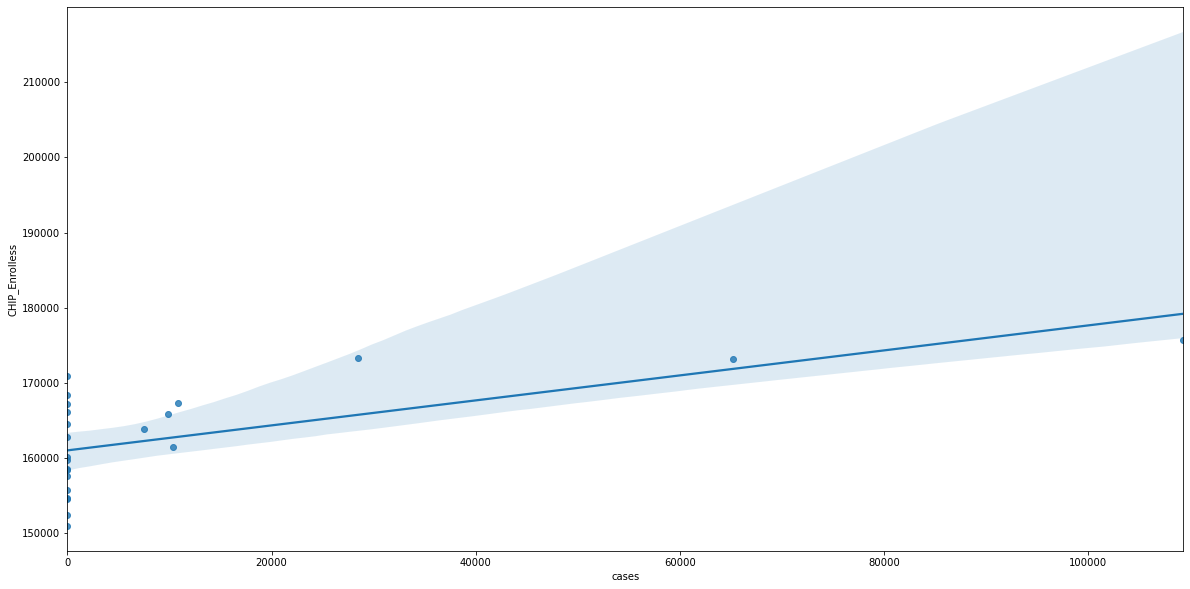

                               OLS Regression Results                               
Dep. Variable:     Total_Medicaid_Enrollees   R-squared:                       0.272
Model:                                  OLS   Adj. R-squared:                  0.237
Method:                       Least Squares   F-statistic:                     7.852
Date:                      Thu, 10 Dec 2020   Prob (F-statistic):             0.0107
Time:                              18:55:26   Log-Likelihood:                -273.13
No. Observations:                        23   AIC:                             550.3
Df Residuals:                            21   BIC:                             552.5
Df Model:                                 1                                         
Covariance Type:                  nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------

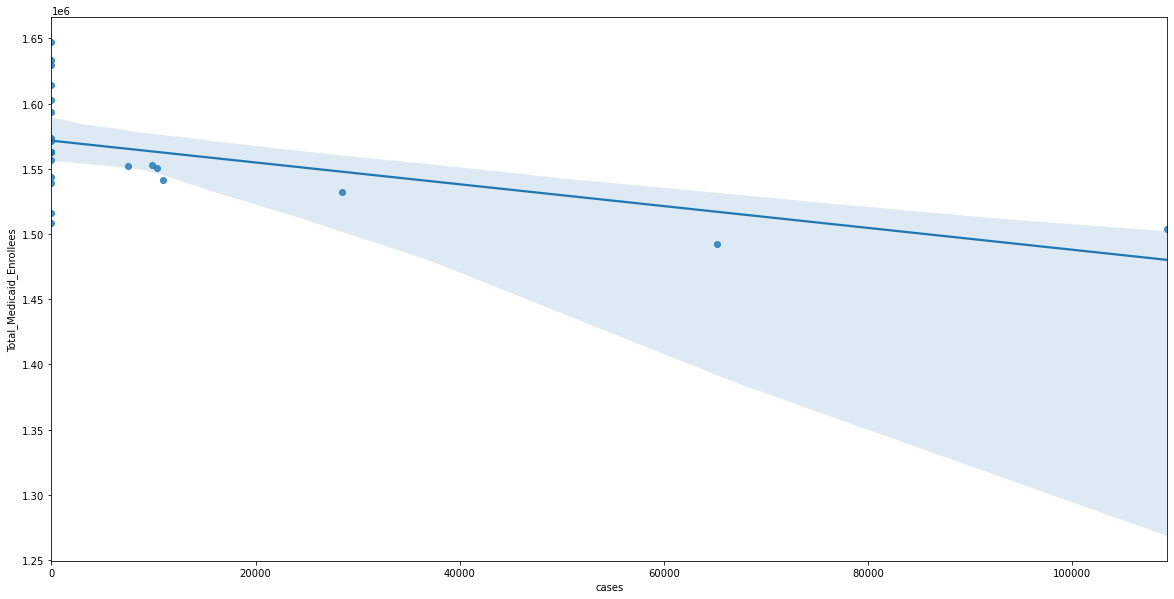

In [19]:
# Esablishing causation between Health Security Indicators (insurance) with COVID-19 Cases 
#(Negative impact on Medicaid Enrollees due to lingering enrollments effect, Postive impact due to increased dropouts causing reduced CHIP enrollments) )
from pandas import DataFrame
import statsmodels.api as sm

#multivariate Linear Regression
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit(regression_df[['cases']],regression_df[['Total_Medicaid_Enrollees','CHIP_Enrolless']])
print(clf.coef_)


# graph and pvalue calculation for CHIP
X = regression_df['cases'] 
Y = regression_df['CHIP_Enrolless']

X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y,X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)
reg(regression_df, 'cases', 'CHIP_Enrolless')

# graph and pvalue calculation for CHIP
X = regression_df['cases'] 
Y = regression_df['Total_Medicaid_Enrollees']

X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y,X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)
reg(regression_df, 'cases', 'Total_Medicaid_Enrollees')

                     cases  Homeless_Numbers  Employed
cases             1.000000         -0.147502 -0.480765
Homeless_Numbers -0.147502          1.000000  0.725273
Employed         -0.480765          0.725273  1.000000


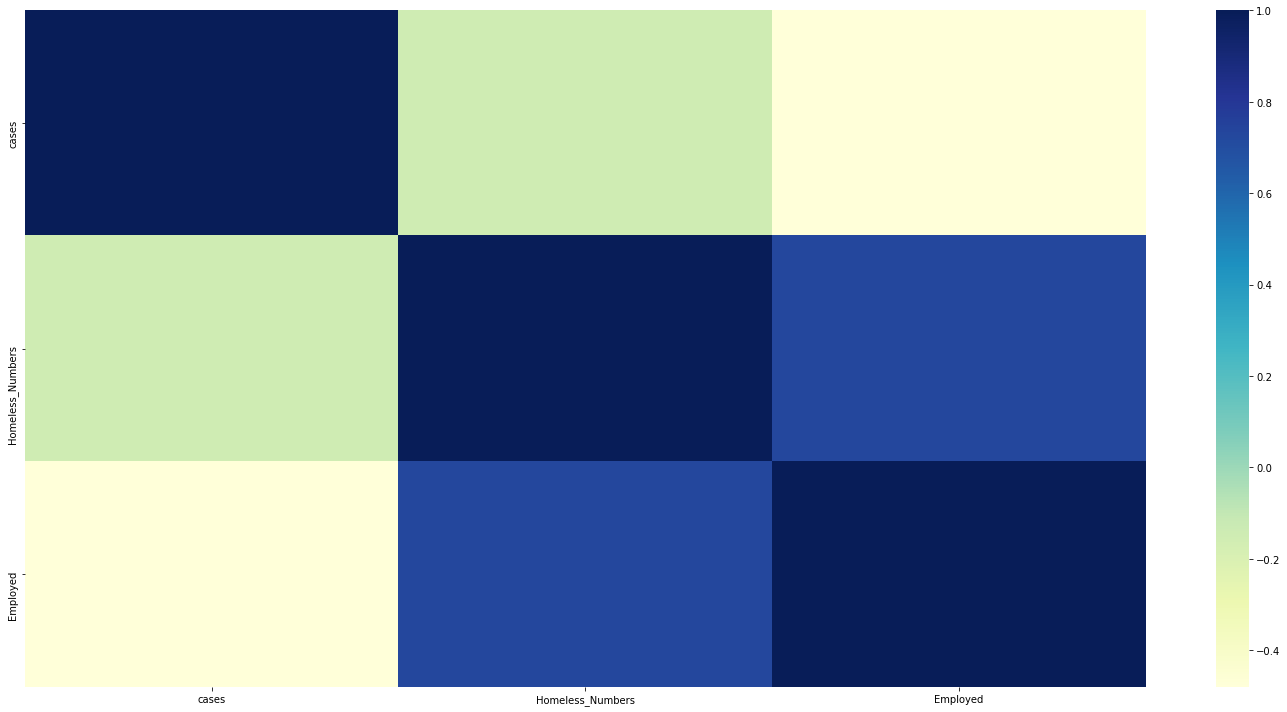

In [20]:


regression_df = (
    left_join_4.select(
        "cases",
        "Homeless_Numbers",
        "Employed"
    )
    .orderBy("date_3")
    .toPandas()
)
regression_df["cases"].fillna(0, inplace=True)
regression_df["Homeless_Numbers"].fillna(regression_df["Homeless_Numbers"].mean(), inplace=True)
regression_df["Employed"].fillna(regression_df["Employed"].mean(), inplace=True)


print(regression_df.corr())
cor_matrix(regression_df)

[[-0.01278587]
 [-0.00629445]]
                            OLS Regression Results                            
Dep. Variable:               Employed   R-squared:                       0.231
Model:                            OLS   Adj. R-squared:                  0.195
Method:                 Least Squares   F-statistic:                     6.313
Date:                Thu, 10 Dec 2020   Prob (F-statistic):             0.0202
Time:                        18:55:44   Log-Likelihood:                -163.18
No. Observations:                  23   AIC:                             330.4
Df Residuals:                      21   BIC:                             332.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       4490.0039

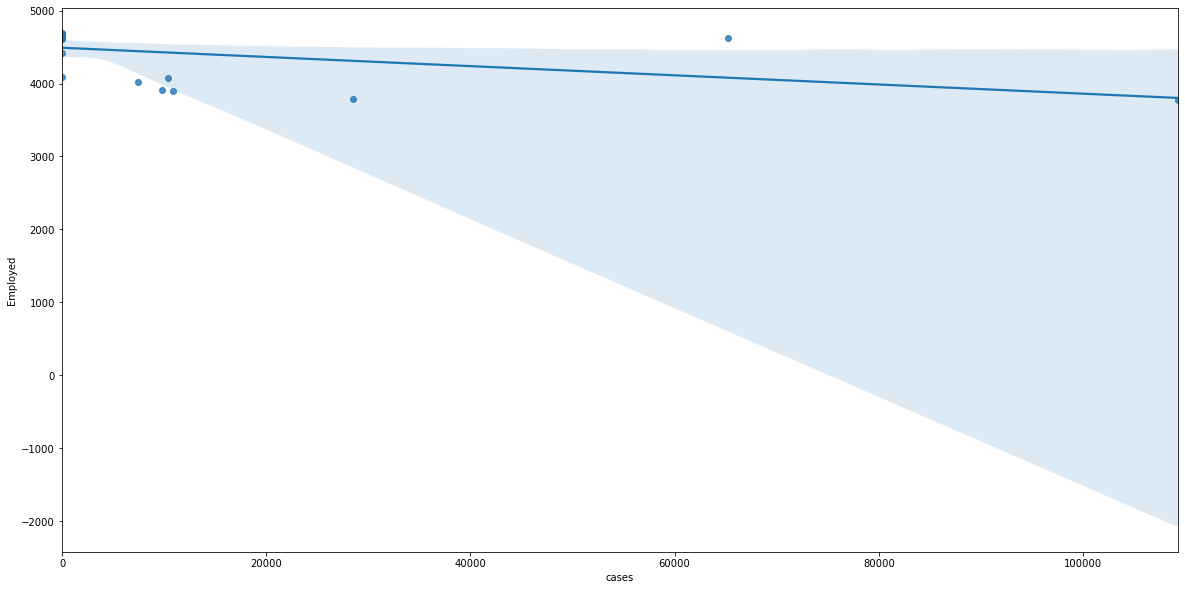

In [21]:
#(Non-significant impact on homelesness, negative impact on employed due to incresed lay-offs) )

#not significant --Employed is significant
from pandas import DataFrame
import statsmodels.api as sm
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit(regression_df[['cases']],regression_df[['Homeless_Numbers','Employed']])
print(clf.coef_)

X = regression_df['cases'] 
Y = regression_df['Employed']

X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)

reg(regression_df, 'cases', 'Employed')

                   cases  shooting_count  arrest_count
cases           1.000000       -0.049692     -0.461931
shooting_count -0.049692        1.000000     -0.613966
arrest_count   -0.461931       -0.613966      1.000000


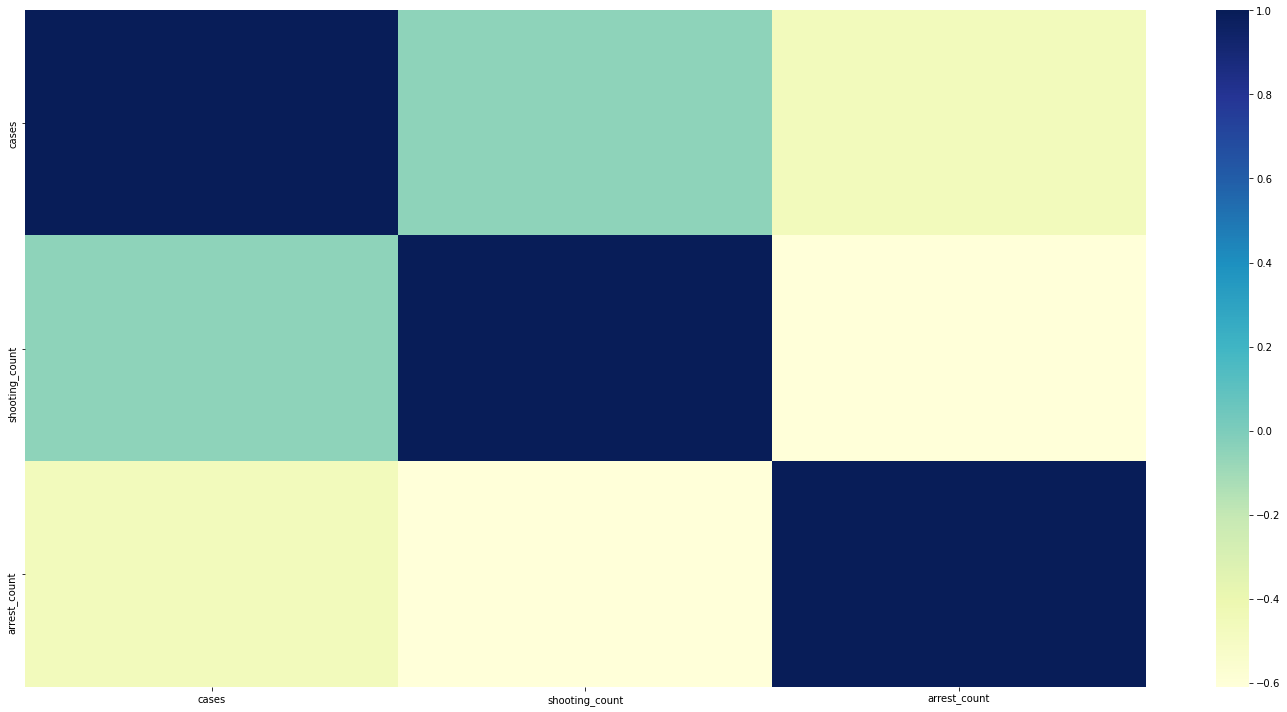

In [22]:
# Correlation of Public Saftey Indicators with COVID-19 Cases
regression_df = (
    left_join_4.select(
        "cases",
        "shooting_count",
        "arrest_count"
    )
    .orderBy("date_3")
    .toPandas()
)
regression_df["cases"].fillna(0, inplace=True)
regression_df["shooting_count"].fillna(regression_df["shooting_count"].mean(), inplace=True)
regression_df["arrest_count"].fillna(regression_df["arrest_count"].mean(), inplace=True)

print(regression_df.corr())
cor_matrix(regression_df)

[[-0.05622446]
 [-0.00011428]]
                            OLS Regression Results                            
Dep. Variable:           arrest_count   R-squared:                       0.213
Model:                            OLS   Adj. R-squared:                  0.176
Method:                 Least Squares   F-statistic:                     5.697
Date:                Thu, 10 Dec 2020   Prob (F-statistic):             0.0265
Time:                        18:56:22   Log-Likelihood:                -214.72
No. Observations:                  23   AIC:                             433.4
Df Residuals:                      21   BIC:                             435.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.442e+04

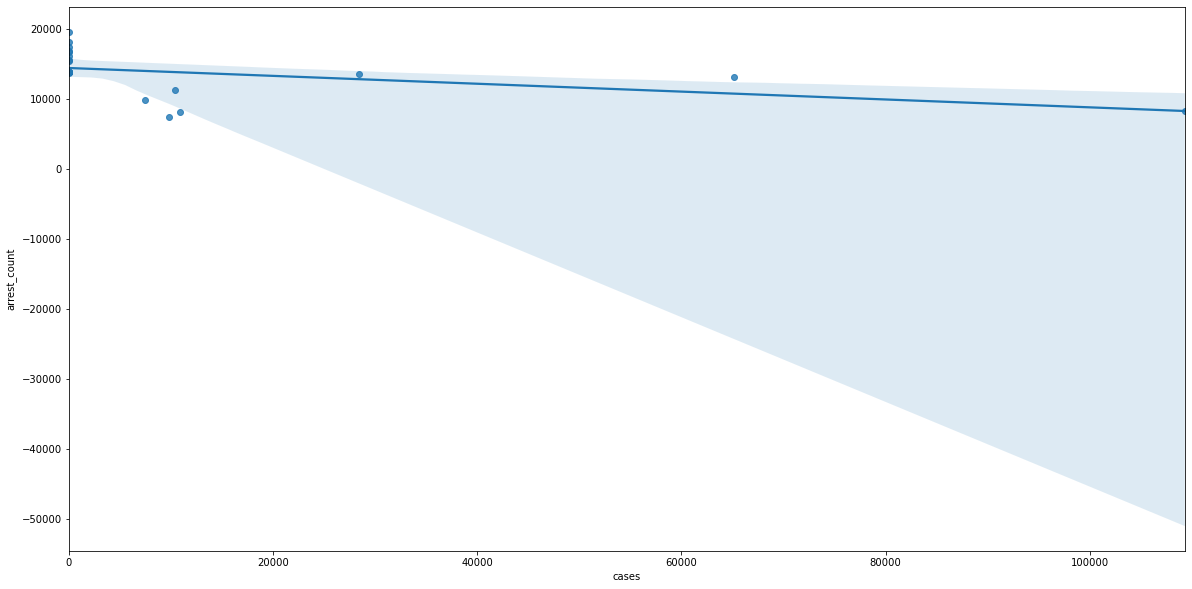

                            OLS Regression Results                            
Dep. Variable:         shooting_count   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.045
Method:                 Least Squares   F-statistic:                   0.05198
Date:                Thu, 10 Dec 2020   Prob (F-statistic):              0.822
Time:                        18:56:22   Log-Likelihood:                -126.17
No. Observations:                  23   AIC:                             256.3
Df Residuals:                      21   BIC:                             258.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         93.4856     13.781      6.784      0.0

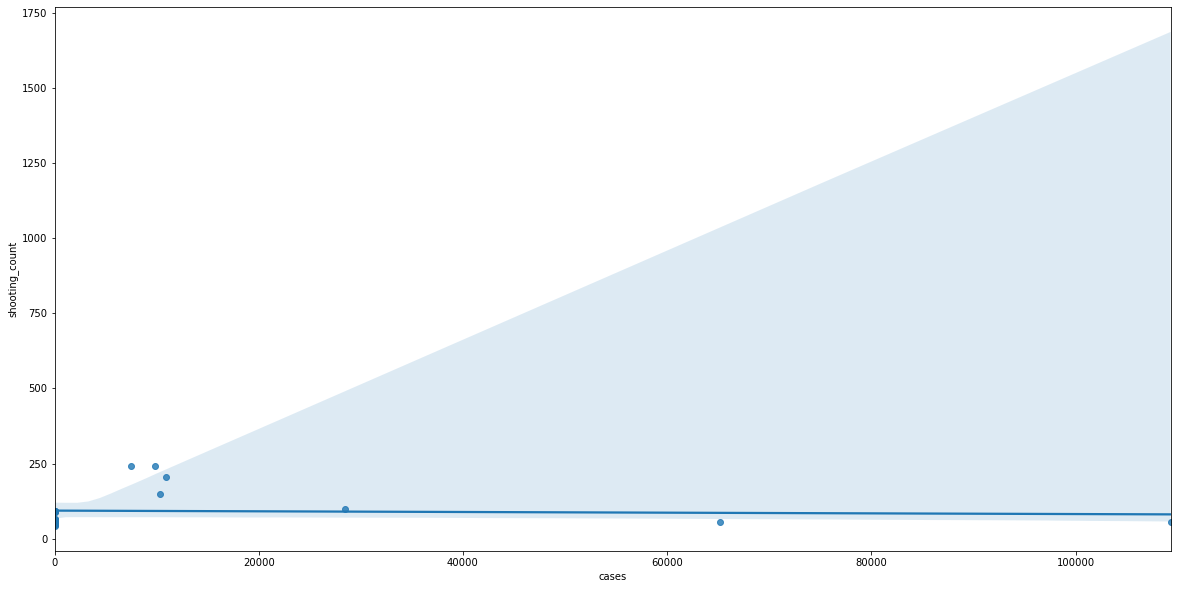

In [23]:
# Esablishing causation between public saftey with COVID-19 Cases 
#(Non-significant impact on shooting_count, negative impact on arrest_count) )


from pandas import DataFrame
import statsmodels.api as sm
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit(regression_df[['cases']],regression_df[["arrest_count","shooting_count"]])
print(clf.coef_)

#p-value and regression graph for arrest _count
X = regression_df['cases'] 
Y = regression_df["arrest_count"]

X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)
reg(regression_df, 'cases', 'arrest_count')

#p-value and regression graph for shooting _count
X = regression_df['cases'] 
Y = regression_df["shooting_count"]

X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)
reg(regression_df, 'cases', 'shooting_count')

                                              cases  \
cases                                      1.000000   
nursing_home_beds_available_prop_pandemic -0.550566   
Ventilator_Beds_Available_prop_pandemic   -0.547632   

                                           nursing_home_beds_available_prop_pandemic  \
cases                                                                      -0.550566   
nursing_home_beds_available_prop_pandemic                                   1.000000   
Ventilator_Beds_Available_prop_pandemic                                     0.987081   

                                           Ventilator_Beds_Available_prop_pandemic  
cases                                                                    -0.547632  
nursing_home_beds_available_prop_pandemic                                 0.987081  
Ventilator_Beds_Available_prop_pandemic                                   1.000000  


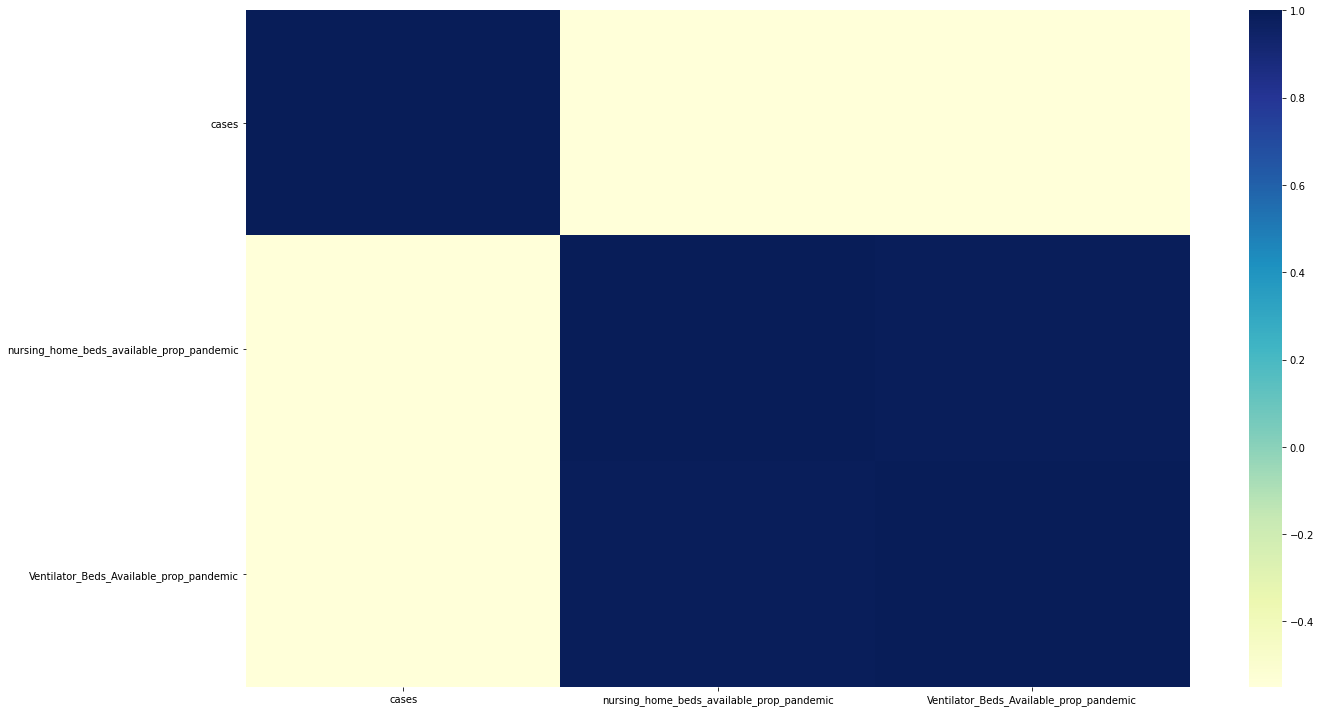

In [24]:

regression_df = (
    left_join_4.select(
        "cases",
        "nursing_home_beds_available_prop_pandemic",
        #"nursing_home_beds_available_prop",
        #"Traumatic_Brain_Injury_Beds_Available_prop",
        "Ventilator_Beds_Available_prop_pandemic"
    )
    .orderBy("date_3")
    .toPandas()
)
regression_df["cases"].fillna(0, inplace=True)
regression_df["nursing_home_beds_available_prop_pandemic"].fillna(regression_df["nursing_home_beds_available_prop_pandemic"].mean(), inplace=True)
#regression_df["nursing_home_beds_available_prop"].fillna(regression_df["nursing_home_beds_available_prop"].mean(), inplace=True)
#regression_df["Traumatic_Brain_Injury_Beds_Available_prop"].fillna(regression_df["Traumatic_Brain_Injury_Beds_Available_prop"].mean(), inplace=True)
regression_df["Ventilator_Beds_Available_prop_pandemic"].fillna(regression_df["Ventilator_Beds_Available_prop_pandemic"].mean(), inplace=True)
print(regression_df.corr())
cor_matrix(regression_df)

[[-1.40572081e-04]
 [-2.60267802e-06]]
                                       OLS Regression Results                                      
Dep. Variable:     Ventilator_Beds_Available_prop_pandemic   R-squared:                       0.300
Model:                                                 OLS   Adj. R-squared:                  0.267
Method:                                      Least Squares   F-statistic:                     8.996
Date:                                     Thu, 10 Dec 2020   Prob (F-statistic):            0.00683
Time:                                             18:56:42   Log-Likelihood:                 20.084
No. Observations:                                       23   AIC:                            -36.17
Df Residuals:                                           21   BIC:                            -33.90
Df Model:                                                1                                         
Covariance Type:                                 nonrobust   

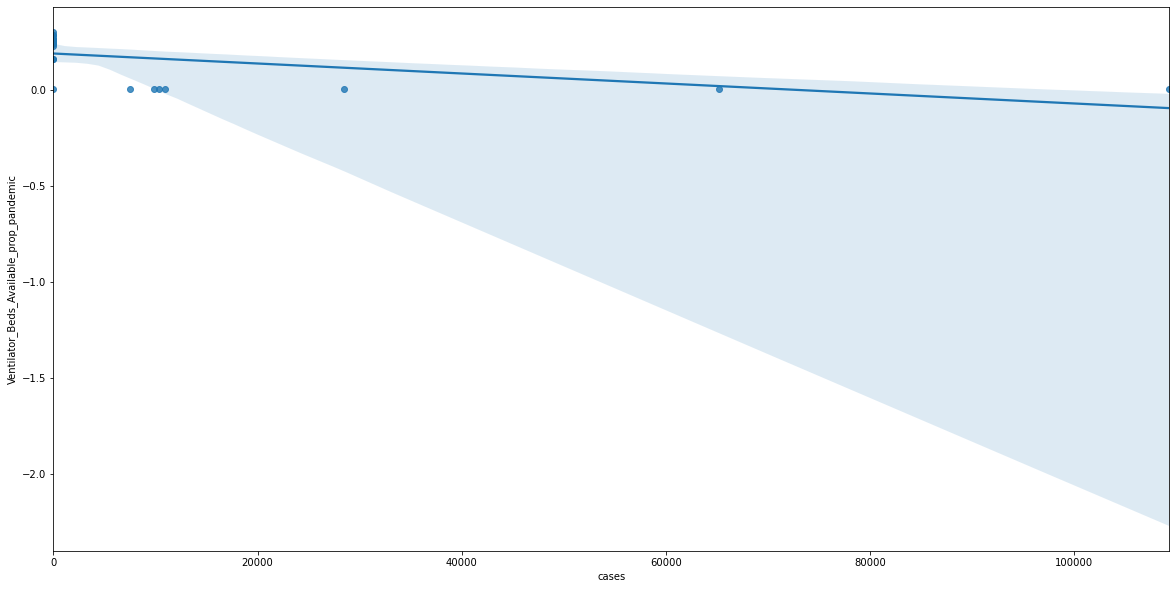

                                        OLS Regression Results                                       
Dep. Variable:     nursing_home_beds_available_prop_pandemic   R-squared:                       0.303
Model:                                                   OLS   Adj. R-squared:                  0.270
Method:                                        Least Squares   F-statistic:                     9.134
Date:                                       Thu, 10 Dec 2020   Prob (F-statistic):            0.00648
Time:                                               18:56:43   Log-Likelihood:                -71.491
No. Observations:                                         23   AIC:                             147.0
Df Residuals:                                             21   BIC:                             149.3
Df Model:                                                  1                                         
Covariance Type:                                   nonrobust                      

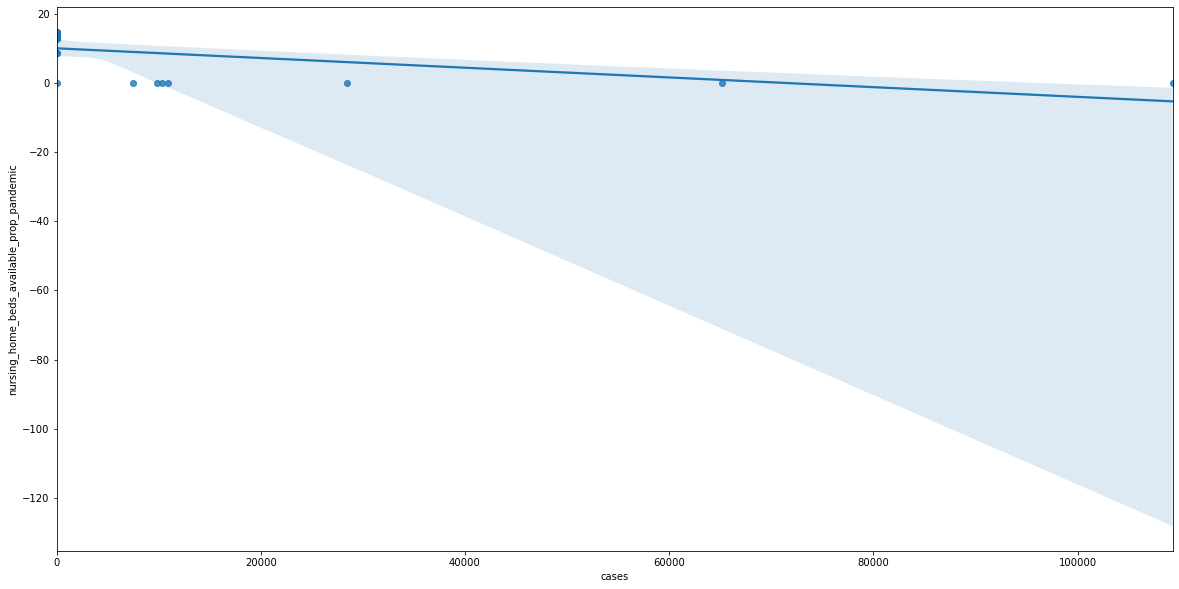

In [25]:

#(All negatively Impacted)

import statsmodels.api as sm
from sklearn import linear_model
clf = linear_model.LinearRegression()
clf.fit(regression_df[['cases']],regression_df[[ "nursing_home_beds_available_prop_pandemic","Ventilator_Beds_Available_prop_pandemic"]])
print(clf.coef_)

# pvalue and graph for Ventilator_Beds_Available_prop_pandemic
X = regression_df['cases'] 
Y = regression_df["Ventilator_Beds_Available_prop_pandemic"]

X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)
reg(regression_df, 'cases', 'Ventilator_Beds_Available_prop_pandemic')

#pvalue and graph for nursing beds availability during pandemics
X = regression_df['cases'] 
Y = regression_df["nursing_home_beds_available_prop_pandemic"]

X = sm.add_constant(X) # adding a constant

model = sm.OLS(Y, X).fit()
predictions = model.predict(X) 

print_model = model.summary()
print(print_model)
reg(regression_df, 'cases', 'nursing_home_beds_available_prop_pandemic')

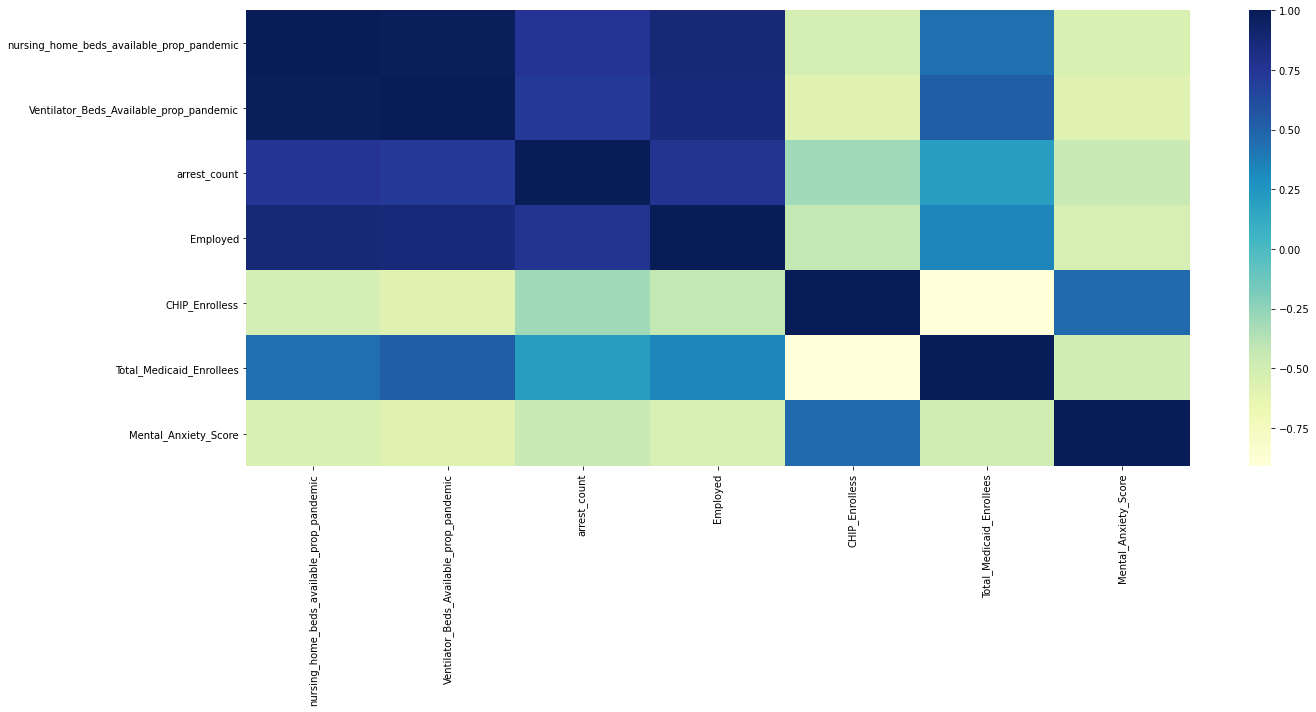

In [26]:
regression_df = (
    left_join_4.select(
        #"cases",
        "nursing_home_beds_available_prop_pandemic",
        #"Pediatric_Beds_available_prop",
        #"Traumatic_Brain_Injury_Beds_Available_prop",
        "Ventilator_Beds_Available_prop_pandemic",
        "arrest_count",
        "Employed",
        "CHIP_Enrolless",
        "Total_Medicaid_Enrollees",
        "Mental_Anxiety_Score"
    )
    .orderBy("date_3")
    .toPandas()
)
#regression_df["cases"].fillna(0, inplace=True)
regression_df["nursing_home_beds_available_prop_pandemic"].fillna(regression_df["nursing_home_beds_available_prop_pandemic"].mean(), inplace=True)
regression_df["Ventilator_Beds_Available_prop_pandemic"].fillna(regression_df["Ventilator_Beds_Available_prop_pandemic"].mean(), inplace=True)
regression_df["arrest_count"].fillna(regression_df["arrest_count"].mean(), inplace=True)
regression_df["Employed"].fillna(regression_df["Employed"].mean(), inplace=True)
regression_df["CHIP_Enrolless"].fillna(regression_df["CHIP_Enrolless"].mean(), inplace=True)
regression_df["Total_Medicaid_Enrollees"].fillna(regression_df["Total_Medicaid_Enrollees"].mean(), inplace=True)
regression_df["Mental_Anxiety_Score"].fillna(regression_df["Mental_Anxiety_Score"].mean(), inplace=True)
cor_matrix(regression_df)

In [27]:



df_cor = regression_df.corr()

vifs = pd.Series(np.linalg.inv(regression_df.corr().values).diagonal(), index=df_cor.index)
print(vifs)

nursing_home_beds_available_prop_pandemic    59.629362
Ventilator_Beds_Available_prop_pandemic      63.543925
arrest_count                                  2.825446
Employed                                      5.081657
CHIP_Enrolless                                6.282340
Total_Medicaid_Enrollees                      6.578214
Mental_Anxiety_Score                          1.802250
dtype: float64


In [28]:

import statsmodels.api as sm

X = regression_df[["nursing_home_beds_available_prop_pandemic",
        #"Pediatric_Beds_available_prop",
        #"Traumatic_Brain_Injury_Beds_Available_prop",
        #"Ventilator_Beds_Available_prop_pandemic",
        "arrest_count",
        "Employed",
        "CHIP_Enrolless",
        "Total_Medicaid_Enrollees"]]

normalized_X=(X-X.min())/(X.max()-X.min())

Y = regression_df["Mental_Anxiety_Score"]

normalized_Y=(Y-Y.min())/(Y.max()-Y.min())

normalized_X = sm.add_constant(normalized_X) # adding a constant

model = sm.OLS(normalized_Y, normalized_X).fit()
predictions = model.predict(normalized_X) 

print_model = model.summary()
print(print_model)

                             OLS Regression Results                             
Dep. Variable:     Mental_Anxiety_Score   R-squared:                       0.405
Model:                              OLS   Adj. R-squared:                  0.230
Method:                   Least Squares   F-statistic:                     2.316
Date:                  Thu, 10 Dec 2020   Prob (F-statistic):             0.0890
Time:                          18:57:18   Log-Likelihood:                 6.4347
No. Observations:                    23   AIC:                           -0.8694
Df Residuals:                        17   BIC:                             5.944
Df Model:                             5                                         
Covariance Type:              nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------